In [1]:
import numpy as np

import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split

# Building the Neural Network
from keras.callbacks import ModelCheckpoint
from keras.models import Model
from keras.layers import Input, Dense, Dropout, Activation, Flatten
from keras.layers.convolutional import Conv2D
from keras.optimizers import Adam

Using TensorFlow backend.


In [2]:
def load_data():
    print('Loading data...')
    loaded = np.load('data/A00-139_first_10000.npz')
    boards = loaded['arr_0']
    targets = loaded['arr_1']
    print('Data loaded.  Splitting data...')
    b_train, b_test, t_train, t_test = train_test_split(boards, targets, test_size=0.25)
    print('Returning output...')
    return b_train, b_test, t_train, t_test

In [3]:
b_train, b_test, t_train, t_test = load_data()

Loading data...
Data loaded.  Splitting data...
Returning output...


### Learning to Play Chess

The initial objective in building the model will to be teach the agent how to play chess by example.  [@oshri2016predicting] offers one method for doing this by using convolutional neural networks to make predictions about the next move based on the board position.  They did this by training seven CNNs, the predict how desirable it was for each piece to move.  The last six were trained to predict the coordinates of a probable move for each piece.  Because of the differing objectives we will need to actually split out the data set into 7 different data sets, each containing only the board positions that are relavent to that CNN.

This brings us to an important point about the CNN model.  We are not going to be giving it whole games at a time, rather pulling out only the specific board states that are relavent to that model. If we consider conceptually what this agent might be learning, because we are removing the flow of the actual game, this agent will probably not be able to reason about long term strategy very well.  Instead its creating a probability model of possible moves (and potentially impossible moves) based on a position. We might interpret this as learning the basic rules of the game, but certainly our agent isn't learning very much grant strategy.  

Long term, we will seek to combine the intuition our agent will build about chess from the CNNs along with other deep learning approaches better suited to learning strategic choices.  These later agents may very likely required the data to be formatted in a different way, but that's work for later.

#### Design Choices

##### Split by color or not
There are a series of choices that I will have to make in creating this model.  First, given that I am already cutting down the data set considerably to only moves for particular pieces, should I split the data further down to just white or black and train individual models.  This is a tough one, because there is both undeniable differences in how black has to play the game, particularly in the start of the game when they are behind a tempo automatically, and similarities in how the game is played no matter which color you are.  All that considered, the goal of *this particular model* is to learn legal and reasonable moves give a board state.  These are not the most strategic moves, as this model will have no conception of the temporal aspect of chess, and so I don't think we need to concern this model with the color of the pieces.

### Preparing the data for CNNs

In [8]:
def b_to_w(boards):
    return np.fliplr(boards)*-1

def convert_colors(b=b_train, t=t_train):
    move_made_by = t[:, 0]
    bbs = b[(move_made_by == "b")]
    bms = t[(move_made_by == 'b')]
    wbs = b[(move_made_by == "w")]
    wms = t[(move_made_by == 'w')]
    bbs_t = np.array([b_to_w(b) for b in bbs])
    bs = np.concatenate([bbs_t, wbs], axis=0)
    ms = np.concatenate([bms, wms], axis=0)
    return bs, ms

def convert_coord(a):
    #print(a)
    board = np.zeros((8, 8))
    board[int(a[0]),int(a[1])] = 1
    return board

def move_selector_data(bs, ms):
    # piece selector data consists of all available board positions. The predictor is the index of the piece
    # that moved (0 through 5).  
    y = np.apply_along_axis(func1d=convert_coord, axis=1, arr=ms[:, 2:4])
    #print(y.shape)
    print("The Move Selector data set contains {} boards".format(y.shape[0]))
    return bs.astype('int'), y.reshape(y.shape[0], 64)

def single_piece_selector_data(bs, ms, piece):
    pieces = ['Pawn', 'Rook', 'Knight', 'Bishop', 'Queen', 'King']
    move_selector = ms[:, 1]
    piece_bs = bs[move_selector == piece]
    piece_ms = ms[move_selector == piece, 4:6]
    y = np.apply_along_axis(func1d=convert_coord, axis=1, arr=piece_ms)
    print("The {} Move Selector data set contains {} boards".format(pieces[int(piece)], piece_ms.shape[0]))
    return piece_bs.astype('int'), y.reshape(y.shape[0], 64)

In [9]:
X_train, y_train = convert_colors()
ms_X_tr, ms_y_tr = move_selector_data(X_train, y_train)
pawn_X_tr, pawn_y_tr = single_piece_selector_data(X_train, y_train, '0') 
rook_X_tr, rook_y_tr = single_piece_selector_data(X_train, y_train, '1')
knight_X_tr, knight_y_tr = single_piece_selector_data(X_train, y_train, '2')
bishop_X_tr, bishop_y_tr = single_piece_selector_data(X_train, y_train, '3')
queen_X_tr, queen_y_tr = single_piece_selector_data(X_train, y_train, '4')
king_X_tr, king_y_tr = single_piece_selector_data(X_train, y_train, '5')

The Move Selector data set contains 633586 boards
The Pawn Move Selector data set contains 166556 boards
The Rook Move Selector data set contains 109582 boards
The Knight Move Selector data set contains 111678 boards
The Bishop Move Selector data set contains 96828 boards
The Queen Move Selector data set contains 73528 boards
The King Move Selector data set contains 75414 boards


In [10]:
X_test, y_test = convert_colors(b_test, t_test)
ms_X_test, ms_y_test = move_selector_data(X_test, y_test)
pawn_X_test, pawn_y_test = single_piece_selector_data(X_test, y_test, '0') 
rook_X_test, rook_y_test = single_piece_selector_data(X_test, y_test, '1')
knight_X_test, knight_y_test = single_piece_selector_data(X_test, y_test, '2')
bishop_X_test, bishop_y_test = single_piece_selector_data(X_test, y_test, '3')
queen_X_test, queen_y_test = single_piece_selector_data(X_test, y_test, '4')
king_X_test, king_y_test = single_piece_selector_data(X_test, y_test, '5')

The Move Selector data set contains 211196 boards
The Pawn Move Selector data set contains 55368 boards
The Rook Move Selector data set contains 36623 boards
The Knight Move Selector data set contains 37045 boards
The Bishop Move Selector data set contains 32622 boards
The Queen Move Selector data set contains 24203 boards
The King Move Selector data set contains 25335 boards


In [33]:
def move_selector_model(kernal_size=(3, 3), conv_layers=2, dense_layers=2):
    BOARD_CHANNELS = 6
    BOARD_ROWS = 8
    BOARD_COLS = 8    
    NB_CLASSES = 64

    # network
    X = Input(shape=(BOARD_CHANNELS, BOARD_COLS, BOARD_ROWS))
    
    Conv = Conv2D(32, kernal_size, padding='same', activation='relu')(X)
    
    if conv_layers > 1:
        for i in range(conv_layers-1):
            Conv = Conv2D(32, kernal_size, padding='same', activation='relu')(Conv)
    
    MLP = Flatten()(Conv)
    
    if dense_layers > 1:
        for i in range(dense_layers-1):
            MLP = Dense(64, activation='relu')(MLP)
    
    predictions = Dense(NB_CLASSES, activation = "softmax")(MLP)
    model = Model(inputs=[X], outputs=[predictions])
    return model

def compile_and_fit_ms_model(X_train, y_train, model, callbacks=[]):
    OPTIMIZER = Adam()
    BATCH_SIZE = 128
    NB_EPOCH = 20
    VALIDATION_SPLIT = 0.2    
    VERBOSE = 1
    
    model.compile(loss="categorical_crossentropy", optimizer=OPTIMIZER, metrics=["accuracy"])
    history = model.fit(X_train, y_train,
                    batch_size=BATCH_SIZE, epochs=NB_EPOCH,
                    verbose=VERBOSE, validation_split=VALIDATION_SPLIT,
                    callbacks=callbacks)
    return model, history

def score_model(X_test, y_test, model):
    VERBOSE = 1
    score = model.evaluate(X_test, y_test, verbose=VERBOSE)
    print("Test score:", score[0])
    print('Test accuracy:', score[1])
    return model, score

def plot_acc_loss(history):
    # list all data in history
    print(history.history.keys())
    # summarize history for accuracy
    plt.plot(history.history['acc'])
    plt.plot(history.history['val_acc'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()
    # summarize history for loss
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()

In [39]:
ms_checkpointer = ModelCheckpoint(filepath='D:\\GitHub\\deepconv-chess\\trained models\\model_selector.hdf5', verbose=1, save_best_only=True)
ms_model, ms_history = compile_and_fit_ms_model(ms_X_tr, ms_y_tr, move_selector_model(), callbacks=[ms_checkpointer])
ms_model, ms_score = score_model(ms_X_test, ms_y_test, ms_model)

Train on 506868 samples, validate on 126718 samples
Epoch 1/20
506868/506868 [==============================] - 21s - loss: 2.8012 - acc: 0.2111 - val_loss: 2.6530 - val_acc: 0.1872
Epoch 2/20
506868/506868 [==============================] - 20s - loss: 2.3924 - acc: 0.2591 - val_loss: 2.4881 - val_acc: 0.2184
Epoch 3/20
506868/506868 [==============================] - 20s - loss: 2.3073 - acc: 0.2742 - val_loss: 2.4666 - val_acc: 0.2233
Epoch 4/20
506868/506868 [==============================] - 20s - loss: 2.2588 - acc: 0.2856 - val_loss: 2.4268 - val_acc: 0.2277
Epoch 5/20
506868/506868 [==============================] - 20s - loss: 2.2245 - acc: 0.2931 - val_loss: 2.4615 - val_acc: 0.2254
Epoch 6/20
506868/506868 [==============================] - 20s - loss: 2.1988 - acc: 0.2996 - val_loss: 2.4602 - val_acc: 0.2262
Epoch 7/20
506868/506868 [==============================] - 21s - loss: 2.1792 - acc: 0.3029 - val_loss: 2.4526 - val_acc: 0.2280
Epoch 8/20
506868/506868 [============

dict_keys(['val_loss', 'val_acc', 'loss', 'acc'])


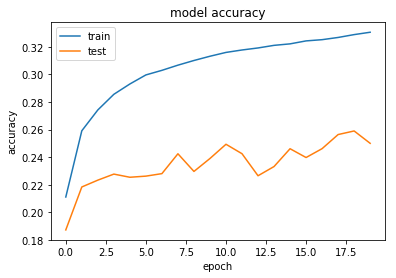

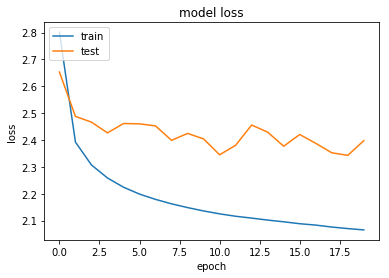

In [40]:
plot_acc_loss(ms_history)

In [42]:
def piece_selector_model(kernal_size=(3, 3), conv_layers=2, dense_layers=2):
    BOARD_CHANNELS = 6
    BOARD_ROWS = 8
    BOARD_COLS = 8    
    NB_CLASSES = 64

    # network
    model = Sequential()
    model.add(Conv2D(32, kernal_size, padding='same',
                     input_shape=(BOARD_CHANNELS, BOARD_COLS, BOARD_ROWS)))
    model.add(Activation('relu'))
    if conv_layers > 1:
        for i in range(conv_layers-1):
            model.add(Conv2D(32, kernal_size, padding='same'))
            model.add(Activation('relu'))
    
    model.add(Flatten())
    if dense_layers > 1:
        for i in range(dense_layers-1):
            model.add(Dense(64))
            model.add(Activation("relu")) 
    
    model.add(Dense(NB_CLASSES))
    model.add(Activation("softmax"))
    return model

def compile_and_fit_ps_model(X_train, y_train, model, callbacks=[]):
    OPTIMIZER = Adam()
    BATCH_SIZE = 128
    NB_EPOCH = 25
    VALIDATION_SPLIT = 0.2    
    VERBOSE = 1
    
    model.compile(loss="categorical_crossentropy", optimizer=OPTIMIZER, metrics=["accuracy"])
    history = model.fit(X_train, y_train,
                    batch_size=BATCH_SIZE, epochs=NB_EPOCH,
                    verbose=VERBOSE, validation_split=VALIDATION_SPLIT,
                    callbacks=callbacks)
    return model, history

In [44]:
pawn_checkpointer = ModelCheckpoint(filepath='D:\\GitHub\\deepconv-chess\\trained models\\pawn_selector.hdf5', verbose=1, save_best_only=True)
pawn_model, pawn_history = compile_and_fit_ps_model(pawn_X_tr, pawn_y_tr, piece_selector_model(), callbacks=[pawn_checkpointer])
pawn_model, pawn_score = score_model(pawn_X_test, pawn_y_test, pawn_model)

Train on 133244 samples, validate on 33312 samples
Epoch 1/25
133244/133244 [==============================] - 6s - loss: 2.8006 - acc: 0.2147 - val_loss: 2.6721 - val_acc: 0.2298
Epoch 2/25
133244/133244 [==============================] - 5s - loss: 2.3735 - acc: 0.3049 - val_loss: 2.5352 - val_acc: 0.2449
Epoch 3/25
133244/133244 [==============================] - 5s - loss: 2.1862 - acc: 0.3400 - val_loss: 2.3739 - val_acc: 0.2744
Epoch 4/25
133244/133244 [==============================] - 5s - loss: 2.0621 - acc: 0.3665 - val_loss: 2.2564 - val_acc: 0.2949
Epoch 5/25
133244/133244 [==============================] - 5s - loss: 1.9754 - acc: 0.3853 - val_loss: 2.2892 - val_acc: 0.2902
Epoch 6/25
133244/133244 [==============================] - 5s - loss: 1.9121 - acc: 0.4000 - val_loss: 2.2140 - val_acc: 0.3172
Epoch 7/25
133244/133244 [==============================] - 5s - loss: 1.8637 - acc: 0.4102 - val_loss: 2.1672 - val_acc: 0.3245
Epoch 8/25
133244/133244 [====================

dict_keys(['val_loss', 'val_acc', 'loss', 'acc'])


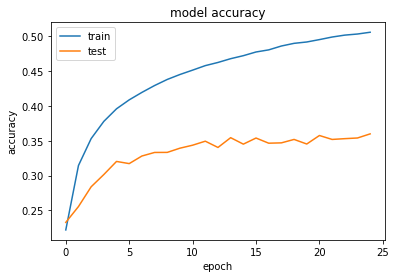

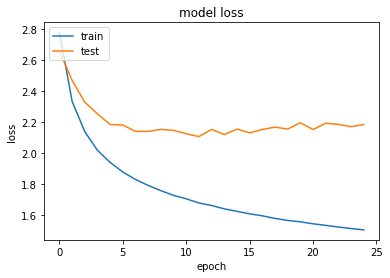

In [16]:
plot_acc_loss(pawn_history)

In [45]:
rook_checkpointer = ModelCheckpoint(filepath='D:\\GitHub\\deepconv-chess\\trained models\\rook_selector.hdf5', verbose=1, save_best_only=True)
rook_model, rook_history = compile_and_fit_ps_model(rook_X_tr, rook_y_tr, piece_selector_model(), callbacks=[rook_checkpointer])
rook_model, rook_score = score_model(rook_X_test, rook_y_test, rook_model)

Train on 87665 samples, validate on 21917 samples
Epoch 1/25
87665/87665 [==============================] - 4s - loss: 3.4918 - acc: 0.1343 - val_loss: 3.3810 - val_acc: 0.1122
Epoch 2/25
87665/87665 [==============================] - 3s - loss: 3.0738 - acc: 0.1882 - val_loss: 3.1427 - val_acc: 0.1495
Epoch 3/25
87665/87665 [==============================] - 3s - loss: 2.8951 - acc: 0.2113 - val_loss: 3.0621 - val_acc: 0.1414
Epoch 4/25
87665/87665 [==============================] - 3s - loss: 2.7759 - acc: 0.2273 - val_loss: 2.9102 - val_acc: 0.1853
Epoch 5/25
87665/87665 [==============================] - 3s - loss: 2.6943 - acc: 0.2391 - val_loss: 2.8941 - val_acc: 0.1852
Epoch 6/25
87665/87665 [==============================] - 3s - loss: 2.6318 - acc: 0.2487 - val_loss: 2.8557 - val_acc: 0.1937
Epoch 7/25
87665/87665 [==============================] - 3s - loss: 2.5822 - acc: 0.2591 - val_loss: 2.8332 - val_acc: 0.1960
Epoch 8/25
87665/87665 [==============================] - 3s 

dict_keys(['val_loss', 'val_acc', 'loss', 'acc'])


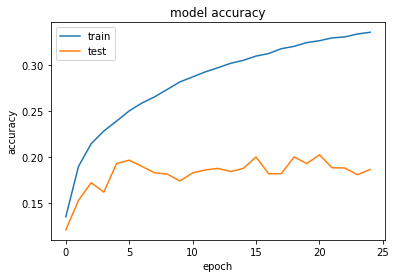

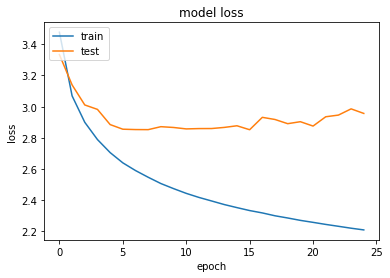

In [18]:
plot_acc_loss(rook_history)

In [46]:
knight_checkpointer = ModelCheckpoint(filepath='D:\\GitHub\\deepconv-chess\\trained models\\knight_selector.hdf5', verbose=1, save_best_only=True)
knight_model, knight_history = compile_and_fit_ps_model(knight_X_tr, knight_y_tr, piece_selector_model(), callbacks=[knight_checkpointer])
knight_model, knight_score = score_model(knight_X_test, knight_y_test, knight_model)

Train on 89342 samples, validate on 22336 samples
Epoch 1/25
89342/89342 [==============================] - 5s - loss: 2.7329 - acc: 0.2876 - val_loss: 2.6571 - val_acc: 0.2626
Epoch 2/25
89342/89342 [==============================] - 3s - loss: 2.2337 - acc: 0.3705 - val_loss: 2.4191 - val_acc: 0.2849
Epoch 3/25
89342/89342 [==============================] - 4s - loss: 2.0425 - acc: 0.4026 - val_loss: 2.2970 - val_acc: 0.3168
Epoch 4/25
89342/89342 [==============================] - 3s - loss: 1.9223 - acc: 0.4281 - val_loss: 2.2284 - val_acc: 0.3346
Epoch 5/25
89342/89342 [==============================] - 3s - loss: 1.8400 - acc: 0.4455 - val_loss: 2.1604 - val_acc: 0.3587
Epoch 6/25
89342/89342 [==============================] - 3s - loss: 1.7707 - acc: 0.4620 - val_loss: 2.0983 - val_acc: 0.3743
Epoch 7/25
89342/89342 [==============================] - 3s - loss: 1.7167 - acc: 0.4744 - val_loss: 2.1544 - val_acc: 0.3612
Epoch 8/25
89342/89342 [==============================] - 3s 

dict_keys(['val_loss', 'val_acc', 'loss', 'acc'])


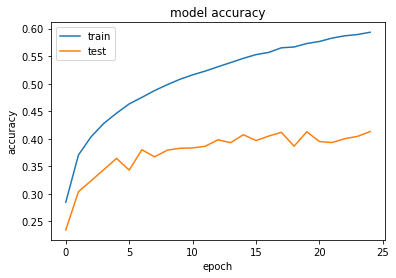

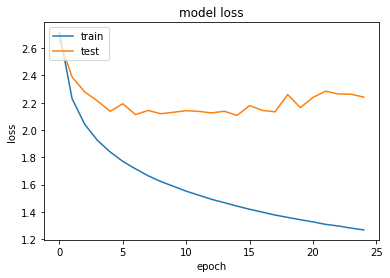

In [20]:
plot_acc_loss(knight_history)

In [47]:
bishop_checkpointer = ModelCheckpoint(filepath='D:\\GitHub\\deepconv-chess\\trained models\\bishop_selector.hdf5', verbose=1, save_best_only=True)
bishop_model, bishop_history = compile_and_fit_ps_model(bishop_X_tr, bishop_y_tr, piece_selector_model(), callbacks=[bishop_checkpointer])
bishop_model, bishop_score = score_model(bishop_X_test, bishop_y_test, bishop_model)

Train on 77462 samples, validate on 19366 samples
Epoch 1/25
77462/77462 [==============================] - 4s - loss: 3.0533 - acc: 0.2236 - val_loss: 2.9009 - val_acc: 0.2411
Epoch 2/25
77462/77462 [==============================] - 3s - loss: 2.5614 - acc: 0.3142 - val_loss: 2.7433 - val_acc: 0.2602
Epoch 3/25
77462/77462 [==============================] - 3s - loss: 2.3662 - acc: 0.3456 - val_loss: 2.6311 - val_acc: 0.2784
Epoch 4/25
77462/77462 [==============================] - 3s - loss: 2.2380 - acc: 0.3693 - val_loss: 2.6093 - val_acc: 0.2676
Epoch 5/25
77462/77462 [==============================] - 3s - loss: 2.1434 - acc: 0.3867 - val_loss: 2.5430 - val_acc: 0.2929
Epoch 6/25
77462/77462 [==============================] - 3s - loss: 2.0678 - acc: 0.4012 - val_loss: 2.5274 - val_acc: 0.2977
Epoch 7/25
77462/77462 [==============================] - 3s - loss: 2.0043 - acc: 0.4162 - val_loss: 2.5155 - val_acc: 0.2987
Epoch 8/25
77462/77462 [==============================] - 3s 

dict_keys(['val_loss', 'val_acc', 'loss', 'acc'])


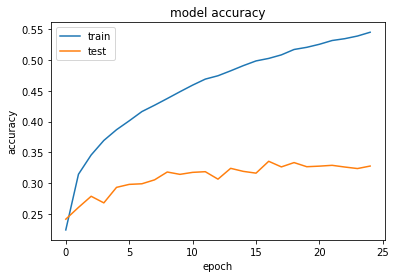

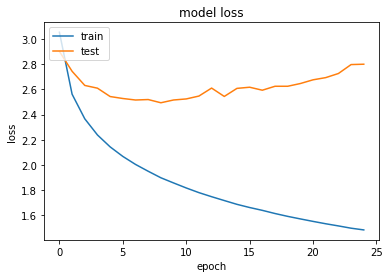

In [50]:
plot_acc_loss(bishop_history)

In [48]:
queen_checkpointer = ModelCheckpoint(filepath='D:\\GitHub\\deepconv-chess\\trained models\\queen_selector.hdf5', verbose=1, save_best_only=True)
queen_model, queen_history = compile_and_fit_ps_model(queen_X_tr, queen_y_tr, piece_selector_model(), callbacks=[queen_checkpointer])
queen_model, queen_score = score_model(queen_X_test, queen_y_test, queen_model)

Train on 58822 samples, validate on 14706 samples
Epoch 1/25
58822/58822 [==============================] - 3s - loss: 3.6504 - acc: 0.1056 - val_loss: 3.5197 - val_acc: 0.1032
Epoch 2/25
58822/58822 [==============================] - 2s - loss: 3.2283 - acc: 0.1738 - val_loss: 3.3178 - val_acc: 0.1396
Epoch 3/25
58822/58822 [==============================] - 2s - loss: 3.0578 - acc: 0.2023 - val_loss: 3.2285 - val_acc: 0.1521
Epoch 4/25
58822/58822 [==============================] - 2s - loss: 2.9443 - acc: 0.2212 - val_loss: 3.1359 - val_acc: 0.1778
Epoch 5/25
58822/58822 [==============================] - 2s - loss: 2.8591 - acc: 0.2346 - val_loss: 3.1466 - val_acc: 0.1718
Epoch 6/25
58822/58822 [==============================] - 2s - loss: 2.7856 - acc: 0.2503 - val_loss: 3.1408 - val_acc: 0.1632
Epoch 7/25
58822/58822 [==============================] - 2s - loss: 2.7274 - acc: 0.2606 - val_loss: 3.1014 - val_acc: 0.1804
Epoch 8/25
58822/58822 [==============================] - 2s 

dict_keys(['val_loss', 'val_acc', 'loss', 'acc'])


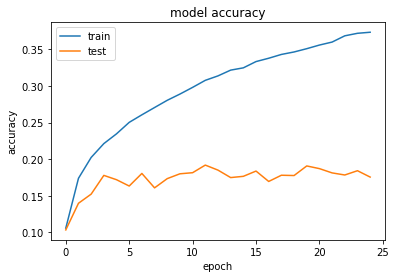

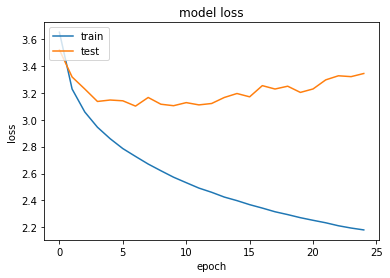

In [51]:
plot_acc_loss(queen_history)

In [49]:
king_checkpointer = ModelCheckpoint(filepath='D:\\GitHub\\deepconv-chess\\trained models\\king_selector.hdf5', verbose=1, save_best_only=True)
king_model, king_history = compile_and_fit_ps_model(king_X_tr, king_y_tr, piece_selector_model(), callbacks=[king_checkpointer])
king_model, king_score = score_model(king_X_test, king_y_test, king_model)

Train on 60331 samples, validate on 15083 samples
Epoch 1/25
60331/60331 [==============================] - 3s - loss: 2.6433 - acc: 0.2638 - val_loss: 2.5321 - val_acc: 0.1615
Epoch 2/25
60331/60331 [==============================] - 2s - loss: 1.9923 - acc: 0.3493 - val_loss: 2.2504 - val_acc: 0.2222
Epoch 3/25
60331/60331 [==============================] - 2s - loss: 1.8350 - acc: 0.3838 - val_loss: 2.0770 - val_acc: 0.2980
Epoch 4/25
60331/60331 [==============================] - 2s - loss: 1.7495 - acc: 0.4077 - val_loss: 2.0204 - val_acc: 0.3074
Epoch 5/25
60331/60331 [==============================] - 2s - loss: 1.6800 - acc: 0.4279 - val_loss: 2.0069 - val_acc: 0.3091
Epoch 6/25
60331/60331 [==============================] - 2s - loss: 1.6215 - acc: 0.4438 - val_loss: 2.0720 - val_acc: 0.2637
Epoch 7/25
60331/60331 [==============================] - 2s - loss: 1.5721 - acc: 0.4597 - val_loss: 2.0097 - val_acc: 0.2975
Epoch 8/25
60331/60331 [==============================] - 2s 

dict_keys(['val_loss', 'val_acc', 'loss', 'acc'])


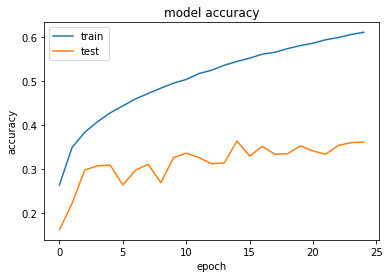

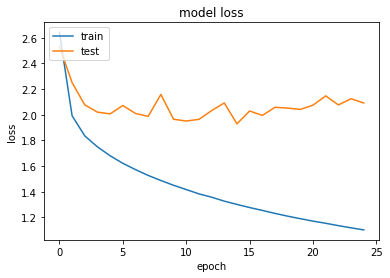

In [52]:
plot_acc_loss(king_history)